# Load Data And Data Overview

In [2]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud

#  Load Datasets
labeled = pd.read_csv("labeled_reddit_data.csv")      # Primary Data

print("Primary (labeled) data shape:", labeled.shape)

# Inspect Columns to Identify Text Field
print("\nPrimary Data Columns:")
print(labeled.columns)

Primary (labeled) data shape: (600, 4)

Primary Data Columns:
Index(['subreddit', 'account_age_years', 'comment_text', 'toxicity'], dtype='object')


In [3]:

print(labeled.info())
print(labeled.describe())
print(labeled.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   subreddit          600 non-null    object 
 1   account_age_years  600 non-null    float64
 2   comment_text       600 non-null    object 
 3   toxicity           600 non-null    int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 18.9+ KB
None
       account_age_years   toxicity
count         600.000000  600.00000
mean            6.771683    0.09500
std             4.716467    0.29346
min             0.010000    0.00000
25%             2.297500    0.00000
50%             6.585000    0.00000
75%            10.517500    0.00000
max            17.660000    1.00000
  subreddit  account_age_years  \
0    gaming               2.89   
1    gaming               8.70   
2    gaming               0.92   
3    gaming               0.76   
4    gaming               5.16   

           

# Missing Values And Data Types

In [4]:
#missing values
print(labeled.isna().sum())

subreddit            0
account_age_years    0
comment_text         0
toxicity             0
dtype: int64


In [5]:
# Duplicates
print(labeled.duplicated().sum())

1


In [6]:
labeled.drop_duplicates(inplace=True)


In [7]:
print(len(labeled))

599


# Normalization

In [8]:
import re

def clean_text(text):
    text = re.sub(r'http\S+', '', text)  # remove links
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # remove non-letters
    return text.lower().strip()

labeled['clean_text'] = labeled['comment_text'].apply(clean_text)

labeled['length'] = labeled['clean_text'].apply(len)


# Univariate Analysis

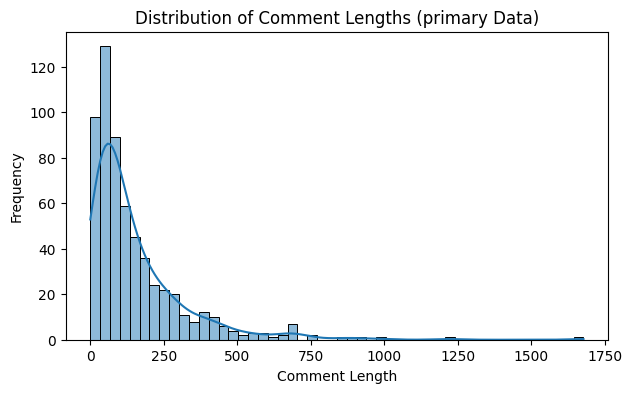

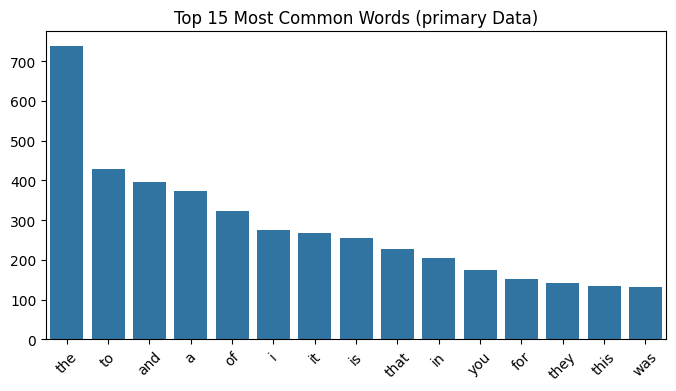

In [12]:
#  A. primary Data
plt.figure(figsize=(7,4))
sns.histplot(labeled['length'], bins=50, kde=True)
plt.title("Distribution of Comment Lengths (primary Data)")
plt.xlabel("Comment Length")
plt.ylabel("Frequency")
plt.show()

# Word Frequency in Secondary Data
words = " ".join(labeled['clean_text']).split()
top_words = Counter(words).most_common(15)
plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
plt.title("Top 15 Most Common Words (primary Data)")
plt.xticks(rotation=45)
plt.show()


# Since The Most Common Words Are All Stop Words Then We Can Remove Stop Words

In [14]:
import nltk
from nltk.corpus import stopwords

# Download stopword list if not already installed
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def clean_text_no_stopwords(text):
    # You can reuse your earlier clean_text function, but add stopword removal
    words = re.sub(r"[^a-zA-Z\s]", "", str(text)).lower().split()
    words = [word for word in words if word not in stop_words and len(word) > 2]
    return " ".join(words)

# Apply this version to a new column so you keep both versions
labeled['clean_text_no_stop'] = labeled['clean_text'].apply(clean_text_no_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


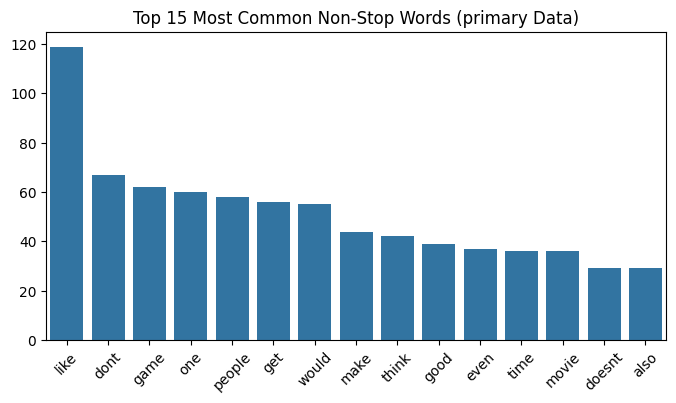

In [15]:
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

words = " ".join(labeled['clean_text_no_stop']).split()
top_words = Counter(words).most_common(15)

plt.figure(figsize=(8,4))
sns.barplot(x=[w[0] for w in top_words], y=[w[1] for w in top_words])
plt.title("Top 15 Most Common Non-Stop Words (primary Data)")
plt.xticks(rotation=45)
plt.show()


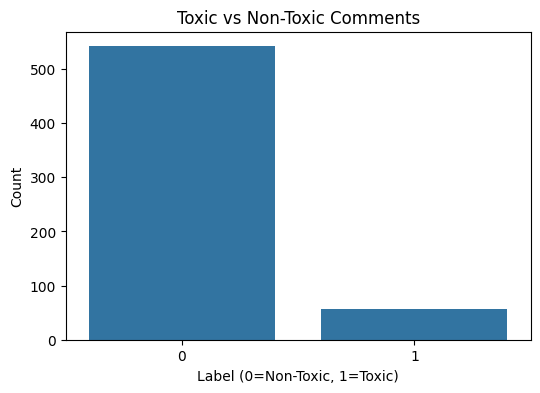

Average comment length (Primary): 152.6


In [16]:

# Toxicity distribution
plt.figure(figsize=(6,4))
sns.countplot(x='toxicity', data=labeled)
plt.title("Toxic vs Non-Toxic Comments")
plt.xlabel("Label (0=Non-Toxic, 1=Toxic)")
plt.ylabel("Count")
plt.show()



# Average lengths
print("Average comment length (Primary):", round(labeled['length'].mean(),2))


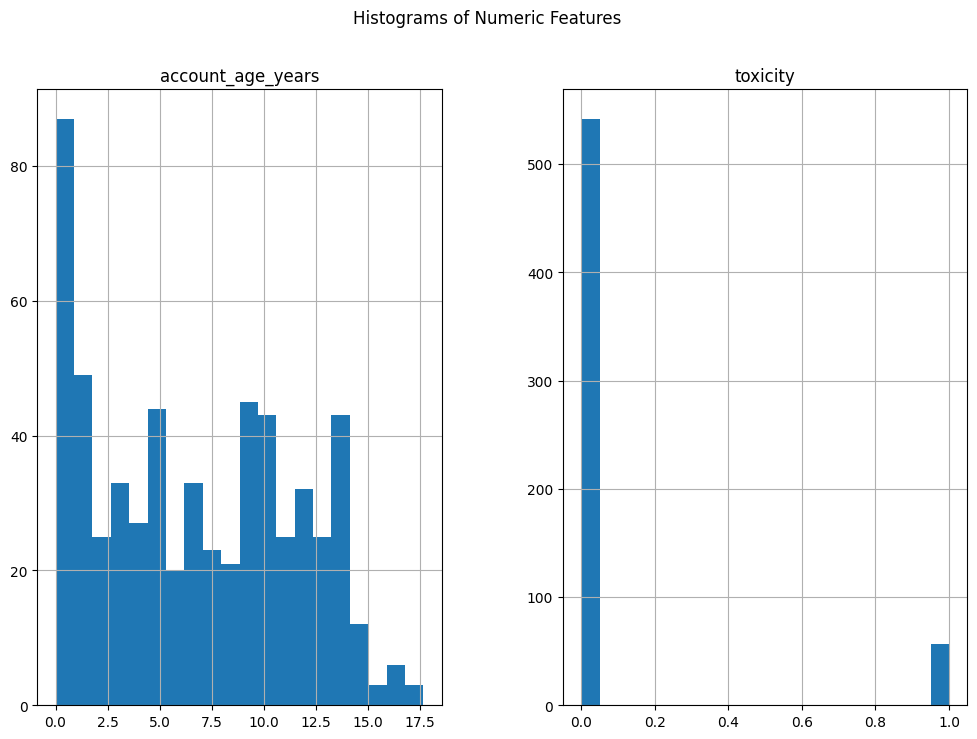

In [23]:
# Histograms for numeric features
labeled[['account_age_years', 'toxicity']].hist(bins=20, figsize=(12, 8))
plt.suptitle('Histograms of Numeric Features')
plt.show()

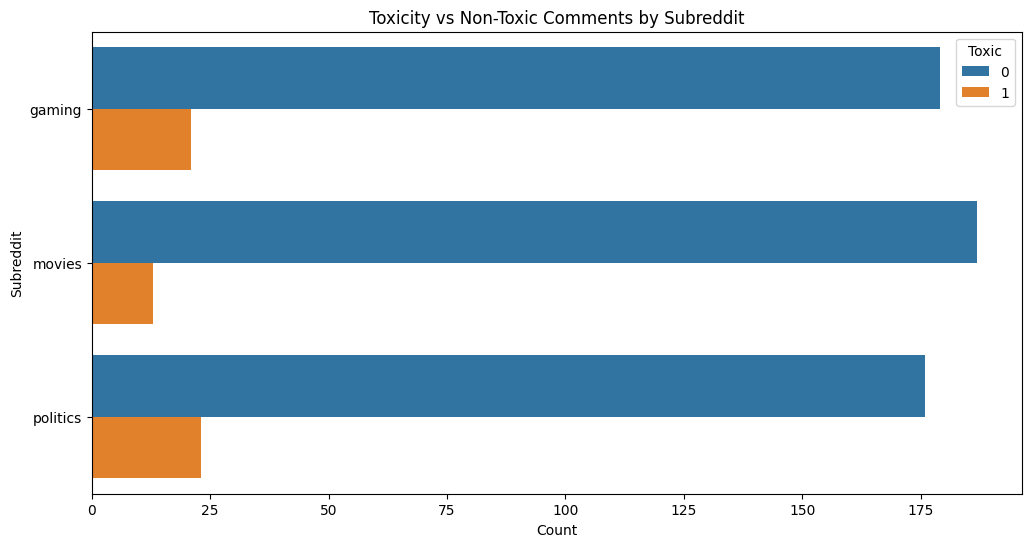

In [30]:
 #Frequency distribution of toxicity (categorical data)
plt.figure(figsize=(12, 6))
sns.countplot(y='subreddit', hue='toxicity', data=labeled,
              order=labeled['subreddit'].value_counts().index[:10])
plt.title('Toxicity vs Non-Toxic Comments by Subreddit')
plt.xlabel('Count')
plt.ylabel('Subreddit')
plt.legend(title='Toxic')
plt.show()


# Multivariate Analysis

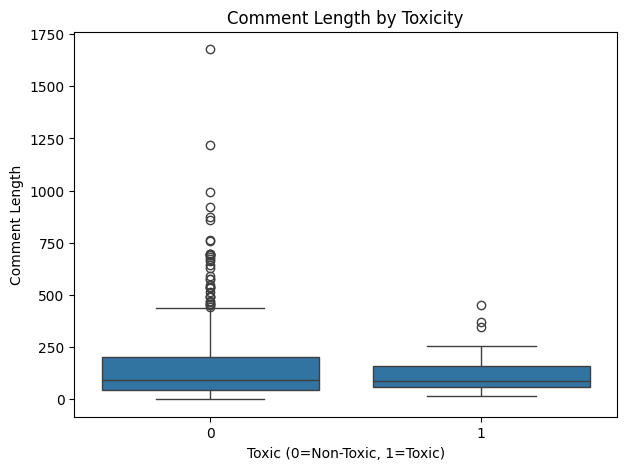

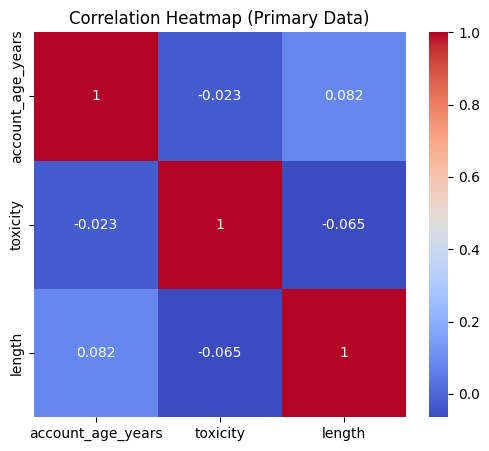

In [17]:
# Toxicity vs Comment Length
plt.figure(figsize=(7,5))
sns.boxplot(x='toxicity', y='length', data=labeled)
plt.title("Comment Length by Toxicity")
plt.xlabel("Toxic (0=Non-Toxic, 1=Toxic)")
plt.ylabel("Comment Length")
plt.show()

# --- Correlation heatmap ---
plt.figure(figsize=(6,5))
sns.heatmap(labeled.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap (Primary Data)")
plt.show()

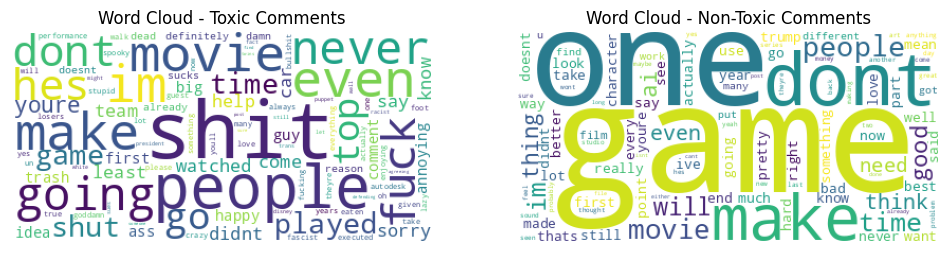

In [ ]:
# Word Clouds for Toxic vs Non-Toxic
toxic_text = " ".join(labeled[labeled['toxicity']==1]['clean_text'])
nontoxic_text = " ".join(labeled[labeled['toxicity']==0]['clean_text'])

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(WordCloud(max_words=100, background_color='white').generate(toxic_text))
plt.axis("off")
plt.title("Word Cloud - Toxic Comments")

plt.subplot(1,2,2)
plt.imshow(WordCloud(max_words=100, background_color='white').generate(nontoxic_text))
plt.axis("off")
plt.title("Word Cloud - Non-Toxic Comments")
plt.show()

# Bias Analysis

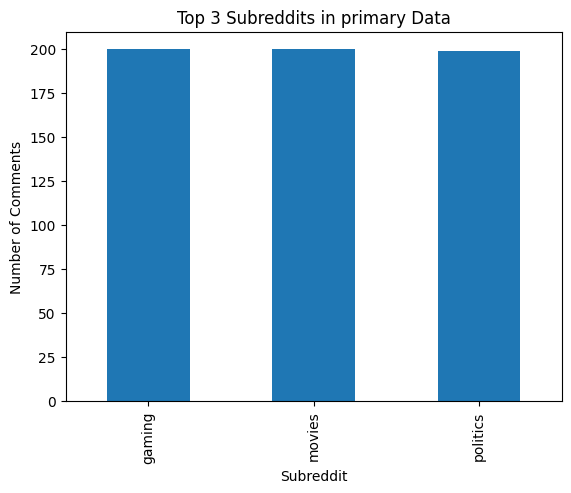

In [20]:
if 'subreddit' in labeled.columns:
    labeled['subreddit'].value_counts().head(10).plot(kind='bar')
    plt.title("Top 3 Subreddits in primary Data")
    plt.xlabel("Subreddit")
    plt.ylabel("Number of Comments")
    plt.show()
